# Web Scraping in Python: Gathering NBA Player Information

Erick Lu

March 22, 2020

## Introduction

In this project, I use Python’s `urllib` and `re` modules to “scrape” ESPN for stats on all the players in the NBA. I then use `pandas` to format the data into a DataFrame, and calculate some interesting statistics.

Web scraping is a useful technique for extracting data from websites that don’t offer formatted, raw data for download. You can write scripts in Python to automate the process of obtaining information from these websites, so that you don’t have to spend hours flipping through each page and copy-pasting.

As an example, I will be scraping data from the rosters for each team in the NBA (as of currently, March 2020) for data such as age, height, weight, and salary. I will also loop through each individual player's stats page and extract career averages such as points per game, free throw percentages, and more.

We can use the data to answer questions such as:

* Do factors such as age, height, weight, etc. correlate with player performance? (i.e. does height matter?)
* How much do better players cost? Can we model the average price of hiring a player given his performance? If so, what is the cost per increase in points per game?
* What is the average salary paid by each team in the NBA, and which player earns the most on each team?

I've also exported the data to a nicely organized csv file, accessible in the GitHub repo for this project if you would like to analyze it yourself. You can also run the python script `scrape_nba_player_stats.py` to re-scrape ESPN yourself to obtain the latest data.

In the following sections, I will describe how to navigate through ESPN, read the page sources using `urllib`, extract information using `re`, and organize player statistics in a `pandas` DataFrame.

## Scrape roster information for each NBA team

We will first take a look at the website to figure out which web pages we need to scrape information from. The teams page at https://www.espn.com/nba/teams looks like the following:

![ESPN_teams_webpage.png](images/ESPN_teams_webpage.png)

This looks very promising. All the team names are listed on this page, which means that they can easily be extracted from the page source. Let’s take a look at the page source to see if we can find the URLs for each team's roster:

![ESPN_teams_source.png](images/ESPN_teams_source.png)

It looks like URLs for each of the teams rosters are listed in the page source with the following format: https://www.espn.com/nba/team/roster/_/name/team/team-name, as shown in the highlighted portion of the image above. Given that these all follow the same format, we can use regular expressions to pull out a list of all the team names from the page source, and then construct the roster URLs using the format above. Start by importing the `urllib` and `re` modules:

In [1]:
import re
import urllib
from time import sleep

Now, let’s create a function that will extract all the team names from http://www.espn.com/nba/teams and construct the each of the team's roster URLs:

In [14]:
# This method finds the urls for each of the rosters in the NBA using regexes.
def build_team_urls():
    # Open the espn teams webpage and extract the names of each roster available.
    f = urllib.request.urlopen('http://www.espn.com/nba/teams')
    teams_source = f.read().decode('utf-8')
    teams = dict(re.findall("www\.espn\.com/nba/team/_/name/(\w+)/(.+?)\",", teams_source))
    # Using the names of the rosters, create the urls of each roster
    roster_urls = []
    for key in teams.keys():
        # each roster webpage follows this general pattern.
        roster_urls.append('http://www.espn.com/nba/team/roster/_/name/' + key + '/' + teams[key])
        teams[key] = str(teams[key])
    return dict(zip(teams.values(), roster_urls))


In [28]:
rosters = build_team_urls()
rosters

{'atlanta-hawks': 'http://www.espn.com/nba/team/roster/_/name/atl/atlanta-hawks',
 'boston-celtics': 'http://www.espn.com/nba/team/roster/_/name/bos/boston-celtics',
 'brooklyn-nets': 'http://www.espn.com/nba/team/roster/_/name/bkn/brooklyn-nets',
 'charlotte-hornets': 'http://www.espn.com/nba/team/roster/_/name/cha/charlotte-hornets',
 'chicago-bulls': 'http://www.espn.com/nba/team/roster/_/name/chi/chicago-bulls',
 'cleveland-cavaliers': 'http://www.espn.com/nba/team/roster/_/name/cle/cleveland-cavaliers',
 'dallas-mavericks': 'http://www.espn.com/nba/team/roster/_/name/dal/dallas-mavericks',
 'denver-nuggets': 'http://www.espn.com/nba/team/roster/_/name/den/denver-nuggets',
 'detroit-pistons': 'http://www.espn.com/nba/team/roster/_/name/det/detroit-pistons',
 'golden-state-warriors': 'http://www.espn.com/nba/team/roster/_/name/gs/golden-state-warriors',
 'houston-rockets': 'http://www.espn.com/nba/team/roster/_/name/hou/houston-rockets',
 'indiana-pacers': 'http://www.espn.com/nba/t

The function `build_team_urls()` returns a dictionary that matches team names with their corresponding roster URL. Given this information, we can systematically loop through all of the team rosters and use regular expressions to extract player information from each roster.

In order to figure out how to scrape the rosters, let’s take a look at the Golden State Warriors' roster page:

![GSW_roster_webpage.png](images/GSW_roster_webpage.png)

Information for each player is nicely laid out in a table, meaning that the data is likely easily obtainable using regular expressions. Taking a look at the page source reveals that each player’s name and information are all provided in blocks of what apppear to be `json`, highlighted below:

![GSW_roster_source.png](images/GSW_roster_source.png)

Given the standardized format of the data for each player, this information is extractable using regular expressions. Let's walk through what the function does. First, we read in the roster webpage using `urllib.request.urlopen`:

In [6]:
url = "https://www.espn.com/nba/team/roster/_/name/gs/golden-state-warriors"
f = urllib.request.urlopen(url)
roster_source = f.read().decode('utf-8')

Then, we construct the regex that will return information for each of the players on the roster webpage.

In [8]:
player_regex = ('\{\"name\"\:\"(\w+\s\w+)\",\"href\"\:\"http\://www\.espn\.com/nba/player/.*?\",(.*?)\}')
player_regex
player_info = re.findall(player_regex, roster_source)
player_info[0:4]

[('Ky Bowman',
  '"uid":"s:40~l:46~a:4065635","guid":"d0ef63e951bb5f842b7357521697dc62","id":"4065635","height":"6\' 1\\"","weight":"187 lbs","age":22,"position":"PG","jersey":"12","salary":"$350,189","birthDate":"06/17/97","headshot":"https://a.espncdn.com/i/headshots/nba/players/full/4065635.png","lastName":"Ky Bowman","experience":0,"college":"Boston College"'),
 ('Marquese Chriss',
  '"uid":"s:40~l:46~a:3907487","guid":"a320ecf1d6481b7518ddc1dc576c27b4","id":"3907487","height":"6\' 9\\"","weight":"240 lbs","age":22,"position":"C","jersey":"32","salary":"$654,469","birthDate":"07/02/97","headshot":"https://a.espncdn.com/i/headshots/nba/players/full/3907487.png","lastName":"Marquese Chriss","experience":3,"college":"Washington","birthPlace":"Sacramento, CA"'),
 ('Stephen Curry',
  '"uid":"s:40~l:46~a:3975","guid":"5dda51f150c966e12026400b73f34fad","id":"3975","height":"6\' 3\\"","weight":"185 lbs","age":32,"position":"PG","jersey":"30","salary":"$40,231,758","birthDate":"03/14/88","h

As you can see, `player_info` is a list of tuples, in which each player name is paired with a set of information (height, weight, age, etc.) that is organized in `json` format. We can use the `json` module in Python to convert the information into a `dict`:

In [9]:
import json
draymond = json.loads("{"+player_info[3][1]+"}")
draymond

{'age': 30,
 'birthDate': '03/04/90',
 'birthPlace': 'Saginaw, MI',
 'college': 'Michigan State',
 'experience': 7,
 'guid': 'de360720e41625f28a6bb5ff82616cb1',
 'headshot': 'https://a.espncdn.com/i/headshots/nba/players/full/6589.png',
 'height': '6\' 6"',
 'id': '6589',
 'jersey': '23',
 'lastName': 'Draymond Green',
 'position': 'PF',
 'salary': '$18,539,130',
 'uid': 's:40~l:46~a:6589',
 'weight': '230 lbs'}

In the example above, all of the pertinent information for Draymond Green is now stored into a Python dictionary. Now that we know we can feasibly extract the player information, let's use the snippets of code above to construct a function in which we loop through each roster in `rosters` and scrape information for each player:

In [47]:
def get_player_info(roster_url):
    f = urllib.request.urlopen(roster_url)
    roster_source = f.read().decode('utf-8')
    sleep(0.5)
    player_regex = ('\{\"name\"\:\"(\w+\s\w+)\",\"href\"\:\"http\://www\.espn\.com/nba/player/.*?\",(.*?)\}')
    player_info = re.findall(player_regex, roster_source)
    player_dict = dict()
    for player in player_info:
        player_dict[player[0]] = json.loads("{"+player[1]+"}")
    return(player_dict)

We will now loop through each team in `rosters` and run `get_player_info()`, storing the output in a dictionary called `all_players`:

In [49]:
all_players = dict()
for team in rosters.keys():
    print("Gathering player info for team: " + team)
    all_players[team] = get_player_info(rosters[team])

Gathering player info for team: boston-celtics
Gathering player info for team: brooklyn-nets
Gathering player info for team: new-york-knicks
Gathering player info for team: philadelphia-76ers
Gathering player info for team: toronto-raptors
Gathering player info for team: chicago-bulls
Gathering player info for team: cleveland-cavaliers
Gathering player info for team: detroit-pistons
Gathering player info for team: indiana-pacers
Gathering player info for team: milwaukee-bucks
Gathering player info for team: atlanta-hawks
Gathering player info for team: charlotte-hornets
Gathering player info for team: miami-heat
Gathering player info for team: orlando-magic
Gathering player info for team: washington-wizards
Gathering player info for team: denver-nuggets
Gathering player info for team: minnesota-timberwolves
Gathering player info for team: oklahoma-city-thunder
Gathering player info for team: portland-trail-blazers
Gathering player info for team: utah-jazz
Gathering player info for team

The `all_players` dictionary should be a dictionary of dictionaries of dictionaries. This sounds complicated, but let's walk through what it looks like. The first level of keys should correspond to teams:

In [50]:
all_players.keys()

dict_keys(['boston-celtics', 'brooklyn-nets', 'new-york-knicks', 'philadelphia-76ers', 'toronto-raptors', 'chicago-bulls', 'cleveland-cavaliers', 'detroit-pistons', 'indiana-pacers', 'milwaukee-bucks', 'atlanta-hawks', 'charlotte-hornets', 'miami-heat', 'orlando-magic', 'washington-wizards', 'denver-nuggets', 'minnesota-timberwolves', 'oklahoma-city-thunder', 'portland-trail-blazers', 'utah-jazz', 'golden-state-warriors', 'la-clippers', 'los-angeles-lakers', 'phoenix-suns', 'sacramento-kings', 'dallas-mavericks', 'houston-rockets', 'memphis-grizzlies', 'new-orleans-pelicans', 'san-antonio-spurs'])

Within a team, the keys should correspond to player names. Let's zoom in on the LA Lakers:

In [51]:
all_players["los-angeles-lakers"].keys()

dict_keys(['Kostas Antetokounmpo', 'Avery Bradley', 'Devontae Cacok', 'Alex Caruso', 'Quinn Cook', 'Anthony Davis', 'Jared Dudley', 'Danny Green', 'Dwight Howard', 'LeBron James', 'Kyle Kuzma', 'JaVale McGee', 'Markieff Morris', 'Rajon Rondo', 'Dion Waiters'])

Now we can choose which player to look at. Let's choose LeBron James as an example:

In [53]:
all_players["los-angeles-lakers"]["LeBron James"]

{'age': 35,
 'birthDate': '12/30/84',
 'birthPlace': 'Akron, OH',
 'experience': 16,
 'guid': '1f6592b3ff53d3218dc56038d48c1786',
 'headshot': 'https://a.espncdn.com/i/headshots/nba/players/full/1966.png',
 'height': '6\' 9"',
 'id': '1966',
 'jersey': '23',
 'lastName': 'LeBron James',
 'position': 'SF',
 'salary': '$37,436,858',
 'uid': 's:40~l:46~a:1966',
 'weight': '250 lbs'}

A dictionary with information about LeBron James is returned. We can extract information even more precisely by specifying which field we are interested in. Let's get his salary:

In [54]:
all_players["los-angeles-lakers"]["LeBron James"]["salary"]

'$37,436,858'

In order to make data analysis easier, we can re-format this dictionary into a pandas DataFrame. The function pd.DataFrame.from_dict() can turn a dictionary of dictionaries into a pandas DataFrame:

In [88]:
import pandas as pd
gsw = pd.DataFrame.from_dict(all_players["golden-state-warriors"], orient = "index")
gsw

,uid,guid,id,height,weight,age,position,jersey,salary,birthDate,headshot,lastName,experience,college,birthPlace,hand
Alen Smailagic,s:40~l:46~a:4401415,6ed3f8924bfef2e70329ebd6a104ecae,4401415,"6' 10""",215 lbs,19,PF,6,"$898,310",08/18/00,https://a.espncdn.com/i/headshots/nba/players/...,Alen Smailagic,0,NaN,NaN,NaN
Andrew Wiggins,s:40~l:46~a:3059319,064c19d065276a21ca99fdfb296fe05d,3059319,"6' 7""",197 lbs,25,SF,22,"$27,504,630",02/23/95,https://a.espncdn.com/i/headshots/nba/players/...,Andrew Wiggins,5,Kansas,"Thornhill, ON",NaN
Chasson Randle,s:40~l:46~a:2580898,71b7154a3d81842448b623ee3e65d586,2580898,"6' 2""",185 lbs,27,PG,25,NaN,02/05/93,https://a.espncdn.com/i/headshots/nba/players/...,Chasson Randle,2,Stanford,"Rock Island, IL",NaN
Damion Lee,s:40~l:46~a:2595209,41fafb6d47a66d8f79f94161918541a4,2595209,"6' 5""",210 lbs,27,SG,1,"$842,327",10/21/92,https://a.espncdn.com/i/headshots/nba/players/...,Damion Lee,2,Louisville,NaN,L
Draymond Green,s:40~l:46~a:6589,de360720e41625f28a6bb5ff82616cb1,6589,"6' 6""",230 lbs,30,PF,23,"$18,539,130",03/04/90,https://a.espncdn.com/i/headshots/nba/players/...,Draymond Green,7,Michigan State,"Saginaw, MI",NaN
Eric Paschall,s:40~l:46~a:3133817,b67e5e0fa5cb209355845d165a49407e,3133817,"6' 6""",255 lbs,23,PF,7,"$898,310",11/04/96,https://a.espncdn.com/i/headshots/nba/players/...,Eric Paschall,0,Villanova,"North Tarrytown, NY",NaN
Jordan Poole,s:40~l:46~a:4277956,4b0492b5a52f267fe84098ef6d2e2bdf,4277956,"6' 4""",194 lbs,20,SG,3,"$1,964,760",06/19/99,https://a.espncdn.com/i/headshots/nba/players/...,Jordan Poole,0,Michigan,"Milwaukee, WI",B
Kevon Looney,s:40~l:46~a:3155535,10a8e77b877324c69966f0c4618caad6,3155535,"6' 9""",222 lbs,24,PF,5,"$4,464,226",02/06/96,https://a.espncdn.com/i/headshots/nba/players/...,Kevon Looney,4,UCLA,"Milwaukee, WI",NaN
Klay Thompson,s:40~l:46~a:6475,3411530a7ab7e8dce4f165d59a559520,6475,"6' 6""",215 lbs,30,SG,11,"$32,742,000",02/08/90,https://a.espncdn.com/i/headshots/nba/players/...,Klay Thompson,8,Washington State,"Los Angeles, CA",NaN
Ky Bowman,s:40~l:46~a:4065635,d0ef63e951bb5f842b7357521697dc62,4065635,"6' 1""",187 lbs,22,PG,12,"$350,189",06/17/97,https://a.espncdn.com/i/headshots/nba/players/...,Ky Bowman,0,Boston College,NaN,NaN


In the DataFrame above, each of the parameters such as 'age', 'salary', etc. are organized in columns and each player is a row. This makes display of the data much easier to read and understand. Furthermore, it also places null values when pieces of data are missing--for example, Chasson Randle's salary information is missing from the website, so 'NaN' is automatically placed in the DataFrame.

DataFrames allow us quickly make calculations, sort players based on their stats, and compare stats between teams. To make a DataFrame containing data from all the teams, we can loop through each team in `all_players`, construct DataFrames, label them with a `team` column, and aggregate them into a single DataFrame called `all_players_df`.

In [127]:
all_players_df = pd.DataFrame()

# loop through each team in all_players, create a pandas DataFrame, and append
for team in all_players.keys():
    team_df = pd.DataFrame.from_dict(all_players[team], orient = "index")
    team_df['team'] = team
    all_players_df = all_players_df.append(team_df)
    
all_players_df

,age,birthDate,birthPlace,college,experience,guid,hand,headshot,height,id,jersey,lastName,position,salary,team,uid,weight
Brad Wanamaker,30,07/25/89,"Philadelphia, PA",Pittsburgh,1,5aad35bbbb760e3958107639266768ae,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 3""",6507,9,Brad Wanamaker,PG,"$1,445,697",boston-celtics,s:40~l:46~a:6507,210 lbs
Carsen Edwards,22,03/12/98,"Houston, TX",Purdue,0,4b8ebdfd01221567925035c1e0d0c337,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"5' 11""",4066407,4,Carsen Edwards,PG,"$1,228,026",boston-celtics,s:40~l:46~a:4066407,200 lbs
Daniel Theis,27,04/04/92,Germany,NaN,2,ce75206c087f83ace6f9a8e3efbd9671,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 8""",2451037,27,Daniel Theis,C,"$5,000,000",boston-celtics,s:40~l:46~a:2451037,245 lbs
Enes Kanter,27,05/20/92,Switzerland,Kentucky,8,1e039b407b3daa6eeac69432aa6413fd,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 10""",6447,11,Enes Kanter,C,"$4,767,000",boston-celtics,s:40~l:46~a:6447,250 lbs
Gordon Hayward,30,03/23/90,"Indianapolis, IN",Butler,9,56f675cb8f40a5aaee5f5747ec9099c5,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 7""",4249,20,Gordon Hayward,SF,"$32,700,690",boston-celtics,s:40~l:46~a:4249,225 lbs
Grant Williams,21,11/30/98,"Houston, TX",Tennessee,0,3a93561dd9c3f1e8de40fbc7b40f7a5e,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 6""",4066218,12,Grant Williams,PF,"$2,379,840",boston-celtics,s:40~l:46~a:4066218,236 lbs
Javonte Green,26,07/23/93,"Alberta, VA",Radford,0,a4940ed033e0a114e8862f5a094aa3f8,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 4""",2596112,43,Javonte Green,SG,"$898,310",boston-celtics,s:40~l:46~a:2596112,205 lbs
Jaylen Brown,23,10/24/96,"Marietta, GA",California,3,0d5cde01f6d3225fdae544ef3304cda2,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 6""",3917376,7,Jaylen Brown,SG,"$6,534,829",boston-celtics,s:40~l:46~a:3917376,223 lbs
Jayson Tatum,22,03/03/98,NaN,Duke,2,ed3343b02ffaf6b4e4223a1920938c81,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 8""",4065648,0,Jayson Tatum,PF,"$7,830,000",boston-celtics,s:40~l:46~a:4065648,210 lbs
Kemba Walker,29,05/08/90,"Bronx, NY",Connecticut,8,665c55b2776846ac62a04efb4c9bcc80,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 0""",6479,8,Kemba Walker,PG,"$32,742,000",boston-celtics,s:40~l:46~a:6479,184 lbs


I'll export this data to a csv file, in case you readers out there want to read it in and play around with it yourself.

In [87]:
all_players_df.to_csv("NBA_roster_info_all_players_mar2020.csv")

## Scrape player stats: career averages

It would be nice to also have data coresponding to the performance of each player, in terms of points per game, field goal percentage, rebounds per game, etc. We can find this information at each player's personal page on ESPN:

![curry_stats_webpage.png](images/curry_stats_webpage.png)

We'll want to extract the career stats in the bottom row, which can be found in the highlighted section of the source code below:

![curry_stats_source.png](images/curry_stats_source.png)

In order to extract this information for each player in our DataFrame, we can construct URLs to open using the `id` column. Fortunately, the URL is standardized and very easy to construct. For example, using the `id` value of 3975 for Stephen Curry, the URL to open would be: https://www.espn.com/nba/player/stats/_/id/3975. Below is an example of extracting the career stats using regexes:

In [233]:
url = "https://www.espn.com/nba/player/stats/_/id/3975"
f = urllib.request.urlopen(url)
sleep(0.3)
player_source = f.read().decode('utf-8')
# extract career stats using this regex
stats_regex = ('\[\"Career\",\"\",(.*?)\]\},\{\"ttl\"\:\"Regular Season Totals\"')
career_info = re.findall(stats_regex, player_source)
career_info


['"699","693","34.3","8.1-17.1","47.6","3.6-8.2","43.5","3.7-4.0","90.6","0.7","3.8","4.5","6.6","0.2","1.7","2.5","3.1","23.5"']

We observe that some of the stats are more than just numerical, such as "FT", which stands for "Free Throws Made-Attempted Per Game". We should split this up into two categories, "Free Throws Made (FTM)" and "Free Throws Attempted (FTA)", and do the same for field goals and 3 pointers. To do so, we can split the string based on "-" and then un-nest the list. Last, we need to convert the strings to floating point values.

In [ ]:
from itertools import chain
career_info = career_info[0].replace("\"", "").split(",")
career_info = list(chain.from_iterable([i.split("-") for i in career_info]))
career_info = list(map(float,career_info))
career_info

Now we can loop through each player in `all_players_df`, open their stats webpage, extract the career stats, and store the stats in a separate data frame called `career_stats_df` using the code below:

In [238]:
career_stats_df = pd.DataFrame(columns = ["GP","GS","MIN","FGM", "FGA","FG%","3PTM","3PTA","3P%","FTM","FTA","FT%","OR","DR","REB","AST","BLK","STL","PF","TO","PTS"])
for player_index in all_players_df.index:
    url = "https://www.espn.com/nba/player/stats/_/id/" + all_players_df.loc[player_index]['id']
    f = urllib.request.urlopen(url)
    sleep(0.3)
    player_source = f.read().decode('utf-8')
    # extract career stats using this regex
    stats_regex = ('\[\"Career\",\"\",(.*?)\]\},\{\"ttl\"\:\"Regular Season Totals\"')
    career_info = re.findall(stats_regex, player_source)
    try:
        # convert the stats to a list of floats, and add the entry to the DataFrame
        career_info = career_info[0].replace("\"", "").split(",")
        career_info = list(chain.from_iterable([i.split("-") for i in career_info]))
        career_info = list(map(float,career_info))
        career_stats_df = career_stats_df.append(pd.Series(career_info, index = career_stats_df.columns, name=player_index))
    except:
        # if no career stats were returned, the player was a rookie.
        print(player_index + " has no info, ", end = "") 

Brad Wanamaker, Carsen Edwards, Daniel Theis, Enes Kanter, Gordon Hayward, Grant Williams, Javonte Green, Jaylen Brown, Jayson Tatum, Kemba Walker, Marcus Smart, Romeo Langford, Semi Ojeleye, Tacko Fall, Tremont Waters, Vincent Poirier, Caris LeVert, Chris Chiozza, DeAndre Jordan, Dzanan Musa, Garrett Temple, Jarrett Allen, Jeremiah Martin, Joe Harris, Justin Anderson, Kevin Durant, Kyrie Irving, Nicolas Claxton, Rodions Kurucs, Spencer Dinwiddie, Taurean Prince, Theo Pinson, Wilson Chandler, Allonzo Trier, Bobby Portis, Damyean Dotson, Elfrid Payton, Frank Ntilikina, Ignas Brazdeikis, Julius Randle, Kadeem Allen, Kenny Wooten has no info, Maurice Harkless, Mitchell Robinson, RJ Barrett, Reggie Bullock, Taj Gibson, Wayne Ellington, Al Horford, Alec Burks, Ben Simmons, Furkan Korkmaz, Joel Embiid, Josh Richardson, Marial Shayok, Matisse Thybulle, Mike Scott, Norvel Pelle, Raul Neto, Shake Milton, Tobias Harris, Zhaire Smith, Chris Boucher, Dewan Hernandez, Fred VanVleet, Kyle Lowry, Mal

Some player webpages did not have career stats, which I found corresponded to rookies which have no games played. This threw an error in the loop, so I used a try/except clause to bypass the error and continue stripping content for the remaining players. The stats are currently stored in the object `career_stats_df`:

In [239]:
career_stats_df

,GP,GS,MIN,FGM,FGA,FG%,3PTM,3PTA,3P%,FTM,...,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
Brad Wanamaker,99.0,1.0,15.7,1.9,4.3,44.0,0.5,1.3,38.0,1.3,...,91.7,0.2,1.4,1.7,2.2,0.1,0.6,1.6,0.9,5.6
Carsen Edwards,35.0,0.0,9.0,1.1,3.2,32.7,0.6,1.9,30.9,0.3,...,84.6,0.2,1.1,1.2,0.6,0.1,0.3,0.9,0.4,3.0
Daniel Theis,187.0,62.0,17.2,2.6,4.7,55.4,0.4,1.1,34.0,1.1,...,75.3,1.6,3.1,4.7,1.2,0.9,0.5,2.8,0.7,6.7
Enes Kanter,634.0,222.0,21.8,4.8,8.8,54.2,0.1,0.2,28.7,2.0,...,77.6,2.9,4.7,7.6,0.9,0.5,0.4,2.2,1.5,11.6
Gordon Hayward,634.0,472.0,30.8,5.2,11.6,45.1,1.3,3.6,36.6,3.5,...,82.2,0.7,3.6,4.4,3.5,0.4,1.0,1.7,2.0,15.3
Grant Williams,62.0,5.0,15.6,1.3,3.1,41.7,0.3,1.4,24.7,0.6,...,72.5,0.9,1.7,2.7,1.0,0.5,0.5,2.4,0.7,3.5
Javonte Green,44.0,1.0,9.4,1.1,2.2,50.0,0.1,0.5,26.1,0.5,...,63.9,0.4,1.4,1.8,0.5,0.2,0.5,0.8,0.4,2.9
Jaylen Brown,272.0,165.0,26.1,4.8,10.3,47.0,1.4,3.7,37.0,1.9,...,68.0,0.8,3.6,4.4,1.4,0.3,0.8,2.4,1.5,12.9
Jayson Tatum,218.0,218.0,31.8,6.2,13.7,45.6,1.8,4.5,39.9,2.9,...,82.7,0.8,5.1,5.9,2.2,0.8,1.1,2.1,1.7,17.2
Kemba Walker,655.0,610.0,33.9,6.9,16.5,41.8,2.2,6.1,36.0,4.0,...,83.8,0.6,3.3,3.8,5.4,0.4,1.3,1.5,2.2,20.0


In [240]:
career_stats_df.to_csv("NBA_player_stats_all_mar2020.csv")

We will now join `career_stats_df` with `all_players_df`, which will merge the content from both data frames based on rows that have the same index (player name). Players in all_players_df that are not included in `career_stats_df` will have NaN values.

In [2]:
all_stats_df = all_players_df.join(career_stats_df)
all_stats_df

NameError: name 'all_players_df' is not defined

In [243]:
all_stats_df.to_csv("NBA_player_info_and_stats_joined_mar2020.csv")

Now that we have gathered and organized the roster data from each team, we can use the data to calculate some statistics. Let's start by calculating average stats per team, using `groupby()` with `mean()` in `pandas`.

In [8]:
all_stats_df = pd.read_csv("NBA_player_info_and_stats_joined_mar2020.csv", index_col=0)
all_stats_df

,age,birthDate,birthPlace,college,experience,guid,hand,headshot,height,id,...,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
Brad Wanamaker,30,07/25/89,"Philadelphia, PA",Pittsburgh,1,5aad35bbbb760e3958107639266768ae,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 3""",6507,...,91.7,0.2,1.4,1.7,2.2,0.1,0.6,1.6,0.9,5.6
Carsen Edwards,22,03/12/98,"Houston, TX",Purdue,0,4b8ebdfd01221567925035c1e0d0c337,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"5' 11""",4066407,...,84.6,0.2,1.1,1.2,0.6,0.1,0.3,0.9,0.4,3.0
Daniel Theis,27,04/04/92,Germany,NaN,2,ce75206c087f83ace6f9a8e3efbd9671,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 8""",2451037,...,75.3,1.6,3.1,4.7,1.2,0.9,0.5,2.8,0.7,6.7
Enes Kanter,27,05/20/92,Switzerland,Kentucky,8,1e039b407b3daa6eeac69432aa6413fd,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 10""",6447,...,77.6,2.9,4.7,7.6,0.9,0.5,0.4,2.2,1.5,11.6
Gordon Hayward,30,03/23/90,"Indianapolis, IN",Butler,9,56f675cb8f40a5aaee5f5747ec9099c5,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 7""",4249,...,82.2,0.7,3.6,4.4,3.5,0.4,1.0,1.7,2.0,15.3
Grant Williams,21,11/30/98,"Houston, TX",Tennessee,0,3a93561dd9c3f1e8de40fbc7b40f7a5e,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 6""",4066218,...,72.5,0.9,1.7,2.7,1.0,0.5,0.5,2.4,0.7,3.5
Javonte Green,26,07/23/93,"Alberta, VA",Radford,0,a4940ed033e0a114e8862f5a094aa3f8,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 4""",2596112,...,63.9,0.4,1.4,1.8,0.5,0.2,0.5,0.8,0.4,2.9
Jaylen Brown,23,10/24/96,"Marietta, GA",California,3,0d5cde01f6d3225fdae544ef3304cda2,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 6""",3917376,...,68.0,0.8,3.6,4.4,1.4,0.3,0.8,2.4,1.5,12.9
Jayson Tatum,22,03/03/98,NaN,Duke,2,ed3343b02ffaf6b4e4223a1920938c81,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 8""",4065648,...,82.7,0.8,5.1,5.9,2.2,0.8,1.1,2.1,1.7,17.2
Kemba Walker,29,05/08/90,"Bronx, NY",Connecticut,8,665c55b2776846ac62a04efb4c9bcc80,NaN,https://a.espncdn.com/i/headshots/nba/players/...,"6' 0""",6479,...,83.8,0.6,3.3,3.8,5.4,0.4,1.3,1.5,2.2,20.0


In [66]:
mean_df = all_stats_df.groupby('team').mean()
mean_df

,age,experience,id,jersey,salary,GP,GS,MIN,FGM,FGA,...,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
team,,,,,,,,,,,,,,,,,,,,,
atlanta-hawks,25.538462,4.307692,3.020583e+06,12.692308,5.608001e+06,314.153846,200.076923,22.215385,3.815385,8.146154,...,74.423077,1.223077,3.184615,4.407692,2.323077,0.569231,0.669231,2.146154,1.430769,10.300000
boston-celtics,25.000000,2.500000,2.753188e+06,30.375000,7.228917e+06,218.000000,121.687500,17.718750,2.787500,6.212500,...,76.050000,0.712500,2.356250,3.081250,1.562500,0.356250,0.612500,1.631250,1.006250,7.662500
brooklyn-nets,25.882353,4.529412,2.423624e+06,12.529412,7.928121e+06,310.823529,214.000000,20.905882,3.482353,7.652941,...,71.711765,0.864706,2.970588,3.835294,2.047059,0.476471,0.641176,1.688235,1.288235,9.582353
charlotte-hornets,24.266667,2.733333,3.090551e+06,13.666667,6.772335e+06,203.400000,103.466667,19.566667,2.626667,5.973333,...,75.086667,0.933333,2.773333,3.680000,1.506667,0.440000,0.626667,1.746667,1.000000,7.013333
chicago-bulls,24.533333,2.533333,3.035302e+06,19.866667,5.392607e+06,199.400000,105.666667,20.033333,3.100000,6.866667,...,73.613333,0.793333,2.580000,3.360000,1.826667,0.326667,0.726667,1.773333,1.020000,8.180000
cleveland-cavaliers,24.866667,2.933333,2.823630e+06,14.266667,8.744085e+06,253.615385,165.538462,20.376923,3.184615,6.953846,...,62.484615,1.246154,3.069231,4.300000,1.638462,0.353846,0.546154,1.692308,1.200000,8.407692
dallas-mavericks,26.416667,3.250000,2.665610e+06,29.333333,7.593353e+06,237.750000,105.666667,19.083333,3.233333,7.058333,...,70.833333,0.791667,2.725000,3.533333,1.808333,0.466667,0.575000,1.566667,1.033333,8.933333
denver-nuggets,25.928571,4.285714,2.803159e+06,16.642857,8.798127e+06,347.153846,185.307692,20.976923,3.423077,7.330769,...,75.776923,1.061538,2.946154,3.984615,2.030769,0.469231,0.700000,1.846154,1.107692,9.092308
detroit-pistons,24.941176,3.411765,2.735654e+06,22.411765,6.505785e+06,235.058824,132.294118,18.876471,2.911765,6.652941,...,64.917647,0.711765,2.335294,3.029412,1.723529,0.341176,0.517647,1.635294,1.000000,7.900000


As you can see, the index of the data frame that is returned corresponds to each individual team now, and the mean values are displayed for each of the columns with numerical values. To find the team with the highest averages for a specific stat, we can use the `sort_values()` function:

We notice that some of the values such as salary have not been included, because they are still strings and contain non-numerical characters such as '$' and ','. We can convert the salary column to numerical by removing all non-numerical characters and converting to `int` using list comprehension:

In [45]:
all_stats_df['salary']=[int(re.sub(r'[^\d.]+', '', s)) if isinstance(s, str) else s for s in all_stats_df['salary'].values]

In [67]:
all_stats_df.sort_values('salary', ascending=False)
all_stats_df['salary'].sort_values(ascending=False).head(10)

Stephen Curry        40231758.0
Chris Paul           38506482.0
Russell Westbrook    38506482.0
John Wall            38199000.0
James Harden         38199000.0
Kevin Durant         38199000.0
LeBron James         37436858.0
Kyle Lowry           34996296.0
Blake Griffin        34449964.0
Jimmy Butler         32742000.0
Name: salary, dtype: float64

In [71]:
mean_df.sort_values('salary', ascending=False)

,age,experience,id,jersey,salary,GP,GS,MIN,FGM,FGA,...,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
team,,,,,,,,,,,,,,,,,,,,,
golden-state-warriors,25.076923,3.153846,2.702354e+06,14.538462,1.173546e+07,244.692308,187.692308,24.076923,4.023077,9.100000,...,77.800000,0.792308,2.853846,3.661538,2.400000,0.384615,0.784615,2.115385,1.430769,11.123077
orlando-magic,24.833333,3.166667,2.539607e+06,14.416667,9.398300e+06,234.416667,136.916667,19.333333,3.016667,6.750000,...,71.383333,0.966667,2.866667,3.841667,1.458333,0.525000,0.625000,1.575000,0.900000,7.816667
oklahoma-city-thunder,25.066667,3.866667,2.935924e+06,14.800000,9.111964e+06,281.533333,187.466667,18.613333,2.560000,5.713333,...,61.446667,0.793333,2.320000,3.106667,1.566667,0.400000,0.680000,1.673333,0.920000,6.973333
philadelphia-76ers,25.714286,3.714286,2.451142e+06,18.857143,8.825191e+06,263.214286,156.785714,20.685714,3.492857,7.550000,...,67.207143,0.857143,3.164286,4.021429,2.107143,0.571429,0.671429,1.835714,1.314286,9.392857
denver-nuggets,25.928571,4.285714,2.803159e+06,16.642857,8.798127e+06,347.153846,185.307692,20.976923,3.423077,7.330769,...,75.776923,1.061538,2.946154,3.984615,2.030769,0.469231,0.700000,1.846154,1.107692,9.092308
cleveland-cavaliers,24.866667,2.933333,2.823630e+06,14.266667,8.744085e+06,253.615385,165.538462,20.376923,3.184615,6.953846,...,62.484615,1.246154,3.069231,4.300000,1.638462,0.353846,0.546154,1.692308,1.200000,8.407692
portland-trail-blazers,25.266667,4.666667,2.717649e+06,16.400000,8.704394e+06,336.066667,247.000000,20.186667,3.626667,7.993333,...,70.940000,1.026667,3.040000,4.080000,1.640000,0.473333,0.620000,1.913333,1.240000,9.786667
miami-heat,27.000000,4.937500,2.183712e+06,25.562500,8.439172e+06,381.266667,210.200000,22.126667,3.326667,7.326667,...,71.233333,0.840000,2.980000,3.833333,2.013333,0.313333,0.713333,1.840000,1.140000,9.180000
utah-jazz,25.857143,3.785714,2.801560e+06,22.285714,8.142802e+06,293.071429,170.214286,18.207143,3.057143,6.535714,...,57.978571,0.800000,2.514286,3.328571,1.757143,0.371429,0.542857,1.457143,1.142857,8.185714


In [74]:
mean_df.corr()

,age,experience,id,jersey,salary,GP,GS,MIN,FGM,FGA,...,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
age,1.000000,0.943116,-0.933036,0.305325,0.181482,0.940997,0.873609,0.555502,0.565419,0.557391,...,-0.023632,0.187555,0.506205,0.435353,0.422943,0.393213,0.556848,0.299680,0.467083,0.619541
experience,0.943116,1.000000,-0.895152,0.075470,0.147095,0.985859,0.946304,0.596198,0.594062,0.598864,...,-0.026614,0.273145,0.543632,0.488831,0.432174,0.449157,0.586659,0.363703,0.516939,0.638133
id,-0.933036,-0.895152,1.000000,-0.231549,-0.224793,-0.881566,-0.839829,-0.590773,-0.594730,-0.590904,...,0.058609,-0.193299,-0.518422,-0.445051,-0.410418,-0.399590,-0.584548,-0.326042,-0.485999,-0.630817
jersey,0.305325,0.075470,-0.231549,1.000000,-0.040033,0.107651,-0.005033,-0.127125,-0.035046,-0.053689,...,-0.092027,-0.351835,-0.137669,-0.207951,-0.104965,-0.184771,-0.044887,-0.210334,-0.122844,0.004749
salary,0.181482,0.147095,-0.224793,-0.040033,1.000000,0.151950,0.257415,0.254496,0.255284,0.286422,...,-0.162242,0.034927,0.215582,0.177464,0.112348,0.100641,0.146015,0.168217,0.161492,0.292824
GP,0.940997,0.985859,-0.881566,0.107651,0.151950,1.000000,0.955467,0.613773,0.611859,0.608144,...,-0.026949,0.314362,0.571460,0.522080,0.434506,0.432908,0.601286,0.344345,0.515046,0.642927
GS,0.873609,0.946304,-0.839829,-0.005033,0.257415,0.955467,1.000000,0.661625,0.663846,0.676777,...,-0.050442,0.348061,0.616044,0.563981,0.480811,0.481158,0.649033,0.408377,0.611432,0.701327
MIN,0.555502,0.596198,-0.590773,-0.127125,0.254496,0.613773,0.661625,1.000000,0.905624,0.912613,...,0.145456,0.562842,0.822409,0.785528,0.830691,0.515868,0.821969,0.799043,0.869195,0.906844
FGM,0.565419,0.594062,-0.594730,-0.035046,0.255284,0.611859,0.663846,0.905624,1.000000,0.984094,...,0.073347,0.546202,0.841600,0.796728,0.838870,0.598628,0.689676,0.693120,0.883822,0.985541
FGA,0.557391,0.598864,-0.590904,-0.053689,0.286422,0.608144,0.676777,0.912613,0.984094,1.000000,...,0.113582,0.476535,0.796968,0.741670,0.823978,0.548187,0.703217,0.701926,0.879038,0.985352


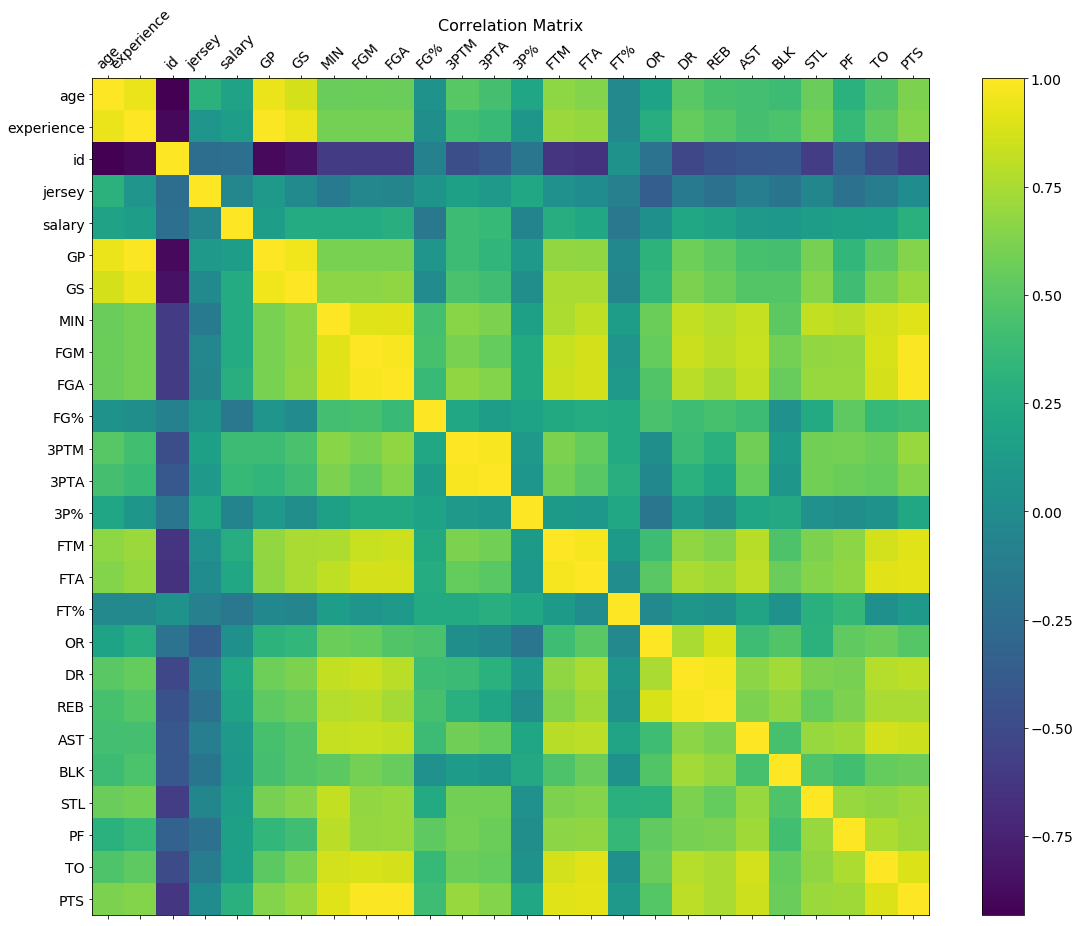

In [75]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(mean_df.corr(), fignum=f.number)
plt.xticks(range(mean_df.shape[1]), mean_df.columns, fontsize=14, rotation=45)
plt.yticks(range(mean_df.shape[1]), mean_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Again, this is achieved by looping through all the team rosters on the ESPN website, then looping through all the players and extracting their salaries.

In general, webpages that link to subpages within the same site construct their links in some sort of standardized pattern. The techniques that I've outlined here should be broadly applicable for other websites. I hope what you've learned from this project will help you out on your own web scraping quests.

Thanks for reading! I hope my code helped you understand how to perform basic web scraping using Python.